In [476]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
# ]

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# # Splitting indices before scaling
# val_days = 30
# val_size = val_days * 24

# train_df = df.iloc[:-val_size]
# val_df = df.iloc[-val_size:]

# # Fit scalers ONLY on training data
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# scaler_x.fit(train_df[features])
# scaler_y.fit(train_df[[target]])

# # Transform entire dataset safely
# X = scaler_x.transform(df[features])
# y = scaler_y.transform(df[[target]])


In [477]:
print(df["price_EUR_MWh"].describe())


count    26022.000000
mean       121.846610
std        108.793671
min       -500.000000
25%         70.640000
50%         98.230000
75%        132.455000
max        872.960000
Name: price_EUR_MWh, dtype: float64


In [478]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=2, dropout=0.15 )
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [479]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.L1Loss()
# criterion = nn.HuberLoss()
# criterion = nn.SmoothL1Loss()

# Training the model
n_epochs = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.3650, Val Loss: 0.1953
Epoch 2, Train Loss: 0.3014, Val Loss: 0.1847
Epoch 3, Train Loss: 0.2521, Val Loss: 0.1729
Epoch 4, Train Loss: 0.2386, Val Loss: 0.1630
Epoch 5, Train Loss: 0.2114, Val Loss: 0.1551
Epoch 6, Train Loss: 0.2066, Val Loss: 0.1562
Epoch 7, Train Loss: 0.1939, Val Loss: 0.1511
Epoch 8, Train Loss: 0.1833, Val Loss: 0.1439
Epoch 9, Train Loss: 0.1858, Val Loss: 0.1459
Epoch 10, Train Loss: 0.2143, Val Loss: 0.1521
Epoch 11, Train Loss: 0.1884, Val Loss: 0.1437
Epoch 12, Train Loss: 0.1889, Val Loss: 0.1348
Epoch 13, Train Loss: 0.1771, Val Loss: 0.1332
Epoch 14, Train Loss: 0.1754, Val Loss: 0.1387
Epoch 15, Train Loss: 0.1718, Val Loss: 0.1369
Epoch 16, Train Loss: 0.2080, Val Loss: 0.1463
Epoch 17, Train Loss: 0.1767, Val Loss: 0.1344
Epoch 18, Train Loss: 0.1751, Val Loss: 0.1312
Epoch 19, Train Loss: 0.1649, Val Loss: 0.1307
Epoch 20, Train Loss: 0.1669, Val Loss: 0.1315
Epoch 21, Train Loss: 0.1649, Val Loss: 0.1374
Epoch 22, Train Loss: 

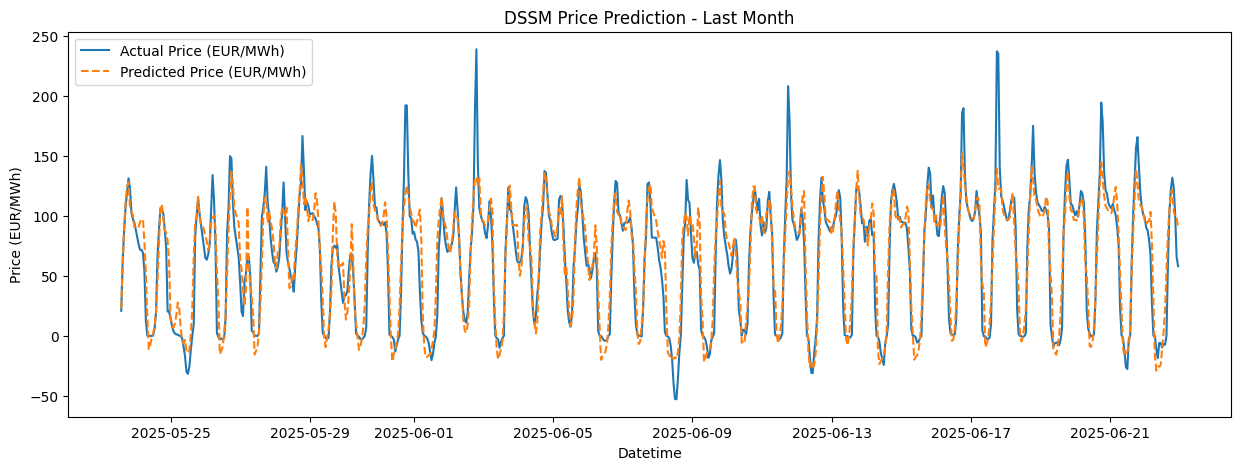

In [480]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [486]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


Validation Set Metrics:
MSE: 377.00
MAE: 13.70


In [487]:
block_size = 6
total_blocks = 28

# Store results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape
    })

block_df = pd.DataFrame(block_metrics)

print("\nPer Block Metrics:")
print(block_df.round(2))

# Group into Horizon Tiers
tiers = {
    "Short-term (0–24h)": block_df.iloc[0:4],
    "Medium-term (24–72h)": block_df.iloc[4:12],
    "Long-term (72–168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].mean()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")


Per Block Metrics:
    Block  Start Hour  End Hour     MSE    MAE       SMAPE
0       1           0         6   12.29   3.38    4.720000
1       2           6        12   48.16   5.24    5.180000
2       3          12        18  713.64  25.73   44.790001
3       4          18        24   70.11   6.58  157.009995
4       5          24        30  109.24   7.29   10.940000
5       6          30        36  877.79  19.40   42.939999
6       7          36        42  265.25  13.85  158.210007
7       8          42        48  163.54  10.96   73.739998
8       9          48        54  674.99  17.55   94.220001
9      10          54        60  142.39   9.82   12.650000
10     11          60        66  296.00  12.91   12.710000
11     12          66        72  647.13  19.05  160.149994
12     13          72        78  476.75  18.63   20.780001
13     14          78        84  615.10  23.89   53.990002
14     15          84        90  514.82  18.84   66.809998
15     16          90        96  436

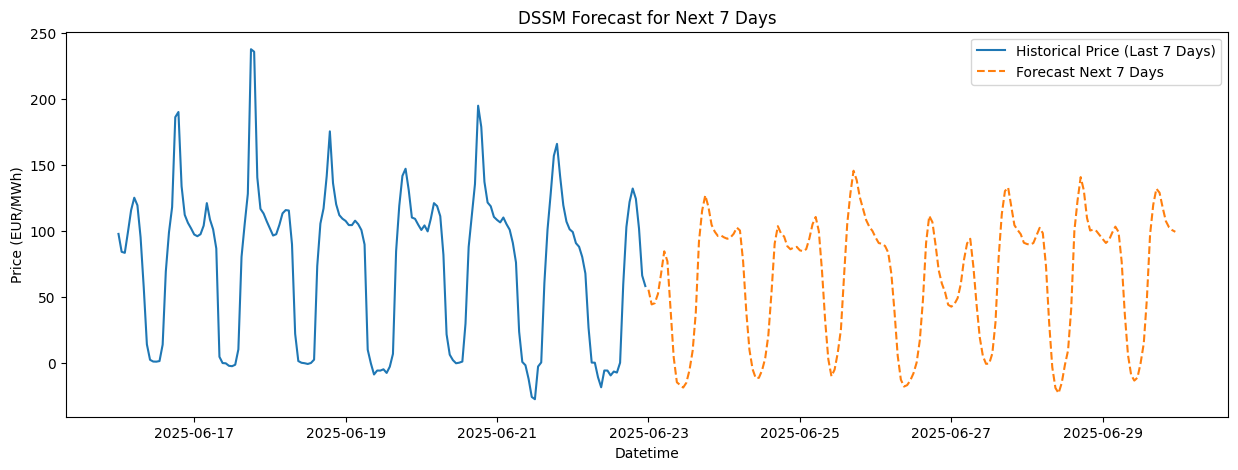

In [482]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0)
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


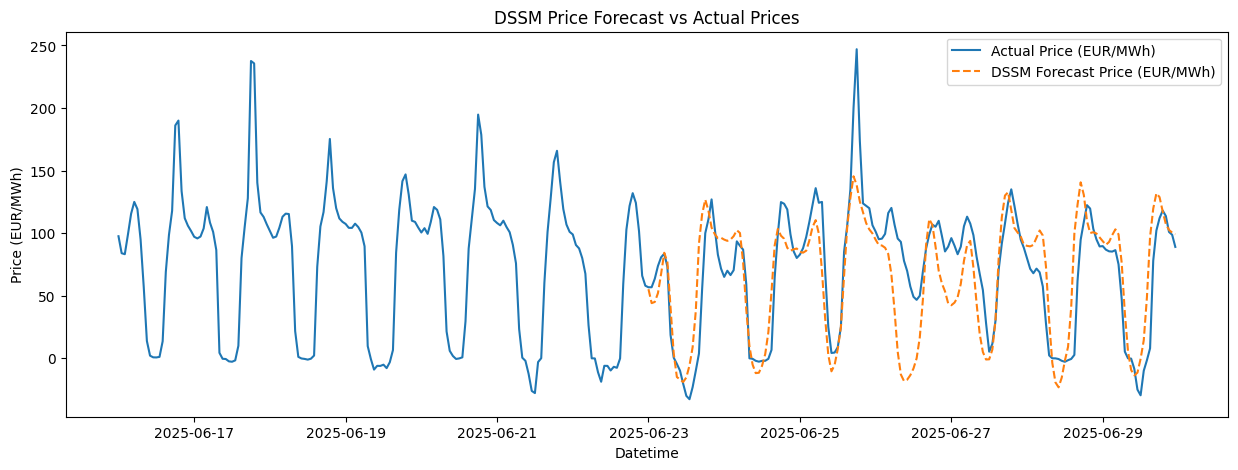

In [483]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506160000", "202506300000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

